<a href="https://colab.research.google.com/github/SPThole/Sidhant_Thole/blob/master/text_classification_pytorch_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
import torch
import transformers
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
import torchtext
import zipfile
import os
from transformers import BertTokenizer as BT
from sklearn.model_selection import train_test_split
import warnings
import torch.nn as nn
warnings.filterwarnings("ignore")
%matplotlib inline

# Plan of Action
1. Import the dataset
- may be by link
- readable format
2. Write the dataset class
- embeddings
3. write dataloader
- batch sizes
5. write model architechture
- transformers transfer learning
6. Write helper funcs for acc
- trainign accuracy, validation accuracy
7. training function
- print history
8. prediction
- test inputs
9. deep dive

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
data = pd.read_csv('/content/drive/My Drive/reviews.csv')

In [5]:
data.head(2)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOH9y0mrXUuqulfB_d48QIXYJet79OMMr8jzm85...,John Oswald-Jacobs,https://play-lh.googleusercontent.com/-jB1fuDT...,Hopeless customer service. I paid for the prem...,1,46,5.6.0.1,2020-09-26 07:30:52,Sorry for the delay in reply! Due to adjusted ...,2020-09-27 10:50:27,most_relevant,com.anydo
1,gp:AOqpTOHNHm4OfbjkxEXXa51JwZEHAaDlvfSgN0OU256...,Lex S,https://play-lh.googleusercontent.com/-FgDpDeE...,"I love this app, but I do have one major gripe...",1,124,5.2.0.23,2020-08-05 16:22:04,"We ensured that Any.do would be fairly priced,...",2020-08-10 07:41:21,most_relevant,com.anydo


In [6]:
data = data[['content','score']]

In [7]:
bins = [0.,2.,3.,5.]
labels = [0,1,2]
data['sentiment'] = pd.cut(data['score'], bins=bins, labels=labels)

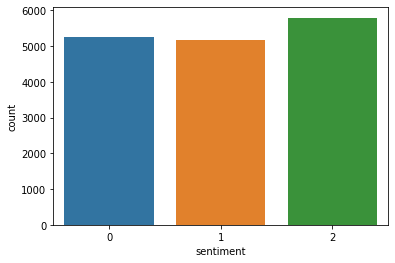

In [8]:
import seaborn as sns
sns.countplot(data['sentiment'])

In [9]:
text = 'well, I just like that anyway'

In [10]:
tokenizer_name = 'bert-base-uncased'
tokenizer = BT.from_pretrained(tokenizer_name)

In [11]:
tokens_txt = tokenizer.tokenize(text)
print(f'tokens are {tokens_txt}')
tokens_ids = tokenizer.convert_tokens_to_ids(tokens_txt)
print(f'ids for above tokens are {tokens_ids}')

tokens are ['well', ',', 'i', 'just', 'like', 'that', 'anyway']
ids for above tokens are [2092, 1010, 1045, 2074, 2066, 2008, 4312]


In [12]:
encoding = tokenizer.encode_plus(
    text = text,
    max_length = 30,
    truncation = True,
    add_special_tokens = True,
    pad_to_max_length = True,
    return_attention_mask=True,
    return_tensors ='pt'
)

In [13]:
type(encoding)

transformers.tokenization_utils_base.BatchEncoding

In [14]:
encoding.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [15]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'well',
 ',',
 'i',
 'just',
 'like',
 'that',
 'anyway',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [16]:
torch.tensor([[2,3],[4,5]]).flatten()

tensor([2, 3, 4, 5])

In [17]:
class SentimentalData(Dataset):
  def __init__(self, text_reviews, labels, max_len, tokenizer):
    self.text = text_reviews
    self.labels = labels
    self.max_len = max_len
    self.tokenizer = tokenizer

  def __getitem__(self,idx):

    text = self.text[idx]
    labels = self.labels[idx]

    encoder = self.tokenizer.encode_plus(
        text = text,
        truncation =True,
        max_length = self.max_len,
        add_special_tokens = True,
        pad_to_max_length = True,
        return_attention_mask=True,
        return_tensors ='pt'
        
    )

    result_dict = {
        'text': text,
        'token_to_ids':encoder['input_ids'].flatten(),
        'token_mask':encoder['attention_mask'].flatten(),
        'label': torch.tensor(labels,dtype=torch.long)
    }

    return result_dict

  def __len__(self):
    return len(self.text)




In [18]:
X = data['content'].values
y = data['sentiment'].values
SEED = 2019

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size =0.2, random_state = SEED)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size =0.2, random_state= SEED)



In [19]:
train_dataset = SentimentalData(X_train, y_train , 180, tokenizer)
val_dataset = SentimentalData(X_val, y_val , 180, tokenizer)
test_dataset = SentimentalData(X_test, y_test , 180, tokenizer)

In [20]:
train_loader = DataLoader(train_dataset, batch_size= 32)
val_loader = DataLoader(val_dataset, batch_size= 32)
test_loader = DataLoader(test_dataset, batch_size= 32)

In [21]:
X_train.shape, X_val.shape, X_test.shape

((12963,), (2592,), (649,))

In [22]:
next(iter(train_loader))['token_to_ids'].shape

torch.Size([32, 180])

In [23]:
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [24]:
last_hidden, output = model(encoding['input_ids'],encoding['attention_mask'])

In [25]:
last_hidden.shape, output.shape

(torch.Size([1, 30, 768]), torch.Size([1, 768]))

In [26]:
class SentimentalModel(nn.Module):
  def __init__(self,pretrained_model,num_classes):
    super(SentimentalModel,self).__init__()
    self.pretrained_model = pretrained_model
    self.tf_layer = nn.Linear(in_features = self.pretrained_model.config.hidden_size, out_features=num_classes)

  def forward(self,input_ids,token_mask):
    _, output = self.pretrained_model(
        input_ids = input_ids,
        attention_mask = token_mask,
    )
    output = self.tf_layer(output)
    return output

    


In [28]:
sentimental_model = SentimentalModel(model,3).to(device)

In [36]:
loss_func = nn.CrossEntropyLoss().to(device)

In [37]:
optimizer = torch.optim.AdamW(sentimental_model.parameters(),lr=0.001)

In [39]:
def accuracy_calc(labels, predictions):
  _,pred_class = torch.max(predictions,dim=1)

  correct_preds = torch.sum(labels==pred_class)

  return correct_preds.item()/len(labels)


def val_loss(val_loader):
  loss = []
  model.eval()
  for i,result_dict in enumerate(val_loader):
    labels = result_dict['label']

    output = model(result_dict)

    val_loss = loss_func(output, labels)

    loss.append(val_loss)

  return np.mean(loss)

def accuracy_epochs(loader):
  model.eval()

  label_list = []

  preds_list = []

  for i,result_dict in enumerate(loader):

    labels = result_dict['label']

    preds = model(result_dict['token_to_ids'],result_dict['token_mask'])

    label_list.append(labels)

    preds_list.append(preds)

  acc_epoch = accuracy_calc(label_list, preds_list)

  return acc_epoch

def sentimentaltrain(model,train_loader,val_loader,epochs,optimizer):
  model.train()
  h = {'train_loss':[],'val_loss':[],'train_acc':[],'val_acc':[]}

  for epoch in range(epochs):
    loss = []
    for i,result_dict in enumerate(train_loader):
      
      token_ids = result_dict['token_to_ids'].to(device)

      token_mask = result_dict['token_mask'].to(device)

      labels = result_dict['label'].to(device)

      output = model(token_ids,token_mask)

      train_loss = loss_func(output, labels)

      train_loss.backward()

      optimizer.step()

      optimizer.zero_grad()

      loss.append(train_loss)

  h['train_loss'].append(np.mean(loss))

  h['val_loss'].append(val_loss(val_loader))

  h['train_acc'].append(accuracy_epochs(train_loader))

  h['val_acc'].append(accuracy_epochs(val_loader))

  print(h)

In [ ]:
sentimentaltrain(sentimental_model,train_loader, val_loader, 10, optimizer)